<a href="https://colab.research.google.com/github/CharleneChar/stanCodeSC201Projects/blob/main/music_emotion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from collections import defaultdict
from itertools import islice
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import statistics
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed): 
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [3]:
def data_preprocessing(data_filename, label_filename):
  print(f'{"*" * 100}')
  # get input data
  input_dim = None
  data_timestamps = defaultdict(list)
  data = defaultdict(list)
  with open(data_filename, 'r') as f:
    f.readline()
    for line in f:
      ele_lst = list(map(float, line.strip().split(',')))
      input_dim = len(ele_lst[2:])
      id = int(ele_lst[0])
      data_timestamps[id].append(ele_lst[1])
      data[id].append(ele_lst[2:])
        
  # get target labels
  target_dim = None
  label_timestamps = defaultdict(list)
  begins = defaultdict(int)
  label_d = defaultdict(list)
  with open(label_filename, 'r') as f:
    f.readline()
    for line in f:
      ele_lst = list(map(float, line.strip().split(',')))
      target_dim = len(ele_lst[2:])
      id = int(ele_lst[0])
      label_timestamps[id].append(ele_lst[1])
      if id not in begins:
        begins[id] = int(ele_lst[1] / 0.5 - 1)
      label_d[id].append(ele_lst[2:])

  # check and get the start time of each collected chorus
  label_begin = 0
  for i in begins.values():
    if i != 30:
      print('there is annotation collected that is not start from 15.5 sec')
    else:
      label_begin = i

  # check every time stamp of both data and label
  for i in data_timestamps.keys():
    if i in label_timestamps.keys():
      if data_timestamps[i] != label_timestamps[i]:
        print('there is data having different time stamps with label\'s timestamps')
        break

  # get input mean and variance
  data_all = [[] for _ in range(input_dim)]
  for dims in data.values():
    for dim in dims:
      for i, dim_v in enumerate(dim):
        data_all[i].append(dim_v)
  data_mean = []
  data_var = []
  for dim_lst in data_all:
    temp_mean, temp_var = statistics.mean(dim_lst), statistics.variance(dim_lst)
    data_mean.append(temp_mean)
    data_var.append(temp_var)

  # get target mean and variance
  label_all = [[] for _ in range(target_dim)]
  for dims in label_d.values():
    for dim in dims:
      for i, dim_v in enumerate(dim):
        label_all[i].append(dim_v)
  label_mean = []
  label_var = []
  for dim_lst in label_all:
    temp_mean, temp_var = statistics.mean(dim_lst), statistics.variance(dim_lst)
    label_mean.append(temp_mean)
    label_var.append(temp_var)

  # get input data distribution
  input_data_len_dict = defaultdict(int)
  for k, v in data.items():
    l = int(len(v) / 10)
    input_data_len_dict[l] += 1

  print("Input Data lengths distribution - ")
  for l in sorted(input_data_len_dict.keys()):
    print('  ' + str(l * 10) + " to " + str(l * 10 + 9) + ": " + str(input_data_len_dict[l]))

  # get target labels distribution
  output_data_len_dict = defaultdict(int)
  for k, v in label_d.items():
    l = int(len(v) / 10)
    output_data_len_dict[l] += 1

  print("Output Data lengths distribution - ")
  for l in sorted(output_data_len_dict.keys()):
    print('  ' + str(l * 10) + " to " + str(l * 10 + 9) + ": " + str(output_data_len_dict[l]))
  print(f'{"*" * 100}')
  print()
  return input_dim, target_dim, data, label_d, label_begin, data_mean, data_var, label_mean, label_var

In [4]:
def data_split(data, label_d):
  # match and get matched indices within data and label
  matched_ids = list(i for i in data.keys() if i in label_d.keys())

  # shuffle matched ids for usage in later random test, train, val split
  random.Random(4).shuffle(matched_ids)

  # split train (70%) and val (20%) and test dataset (10%) of features and labels
  train_sz, val_sz = int(len(data) * 0.7), int(len(data) * 0.2)
  test_sz = len(data) - train_sz - val_sz
  train_ids, val_ids, test_ids = list(islice(matched_ids, train_sz)),  list(islice(matched_ids, train_sz, train_sz + val_sz)), list(islice(matched_ids, train_sz + val_sz, len(data)))
  train_data_X, train_d_Y = [data[key] for key in data if key in train_ids], [label_d[key] for key in label_d if key in train_ids]
  val_data_X, val_d_Y = [data[key] for key in data if key in val_ids], [label_d[key] for key in label_d if key in val_ids]
  test_data_X, test_d_Y = [data[key] for key in data if key in test_ids], [label_d[key] for key in label_d if key in test_ids]

  print(f'{"*" * 100}')
  print(f'Number of matched music ids: {len(matched_ids)}')
  print(f'Random_splitted_sizes: {len(train_ids)} for train, {len(val_ids)} for val, {len(test_ids)} for test')
  print(f'Number of dynamic training input data, target label: {len(train_data_X)}, {len(train_d_Y)}')
  print(f'Number of dynamic validation input data, target label: {len(val_data_X)}, {len(val_d_Y)}')
  print(f'Number of dynamic test input data, target label: {len(test_data_X)}, {len(test_d_Y)}')

  # show music id for usage in demonstration
  sample_music = 0 # ref: id 229 can be manually chosen for better demonstration
  sample_max_length = 0 
  sample_music_idx = 0 # ref: position 13 is corresponding to id 229
  for temp_idx, each_sample_music in enumerate(test_ids):
    if len(label_d[each_sample_music]) > sample_max_length:
      sample_max_length = len(label_d[each_sample_music])
      sample_music = each_sample_music
      sample_music_idx = temp_idx
  print(f'sample music ID: {sample_music}, position index: {sample_music_idx}, music length collected: 1.0 to {1 + len(data[sample_music])*0.5 - 0.5} sec for feature data and 15.5 to {15.5 + len(label_d[sample_music])*0.5 - 0.5} sec for labels')
  print(f'{"*" * 100}')
  print()
  return train_data_X, train_d_Y, val_data_X, val_d_Y, test_data_X, test_d_Y, train_ids, val_ids, test_ids, sample_music, sample_music_idx

In [5]:
# set up dataset class
class PMEmoDataset(Dataset):
  def __init__(self, seqs, labels, max_seq_len=120):
    self.max_seq_len = max_seq_len
    self.seqs, self.seq_lengths = zip(*map(self.pad_seq, seqs))
    self.seqs = np.array(self.seqs, dtype=np.single)
    self.seq_lengths = np.array(self.seq_lengths, dtype=np.single)

    self.labels, self.label_lengths = zip(*map(self.pad_label, labels))
    self.labels = np.array(self.labels, dtype=np.single)
    self.label_lengths = np.array(self.label_lengths, dtype=np.single)

  def pad_label(self, label):
    if len(label) >= self.max_seq_len:
      return np.array(label[:self.max_seq_len]), self.max_seq_len
    return np.pad(label, ((0, self.max_seq_len - len(label)), (0, 0))), len(label)

  def pad_seq(self, seq):
    if len(seq) >= self.max_seq_len:
      return np.array(seq[:self.max_seq_len]), self.max_seq_len
    return np.pad(seq, ((0, self.max_seq_len - len(seq)), (0, 0))), len(seq)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return torch.tensor((self.seqs[idx] - np.array(data_mean)) / np.array(data_var), dtype=torch.float), \
        self.seq_lengths[idx], \
        torch.tensor((self.labels[idx] - np.array(label_mean)) / np.array(label_var), dtype=torch.float), \
        self.label_lengths[idx]

In [6]:
# set up BiLSTM model
class BiLSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional):
    super().__init__()
    self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
    self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)
    self.bi_fc = nn.Linear(in_features=hidden_dim*2, out_features=output_dim)
    nn.init.kaiming_normal_(self.fc.weight)
    nn.init.kaiming_normal_(self.bi_fc.weight)
    nn.init.zeros_(self.fc.bias)
    nn.init.zeros_(self.bi_fc.bias)
  def forward(self, x, input_lengths, bidirectional):
    packed = nn.utils.rnn.pack_padded_sequence(input=x, lengths=input_lengths, batch_first=True, enforce_sorted=False)
    packed_output, (h_n, c_n) = self.bilstm(packed)
    output, _ = nn.utils.rnn.pad_packed_sequence(sequence=packed_output, batch_first=True)
    batch_size = output.data.shape[0]
    out = output[list(range(batch_size)), :, :]
    out = self.bi_fc(out) if bidirectional else self.fc(out)
    return out

# set up TransformerEncoder model
class TransformerEncoderModel(nn.Module):
  def __init__(self, input_dim=260, nhead=10, dim_feedforward=1024, num_layers=2, output_dim=2):
    super().__init__()
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True, norm_first=False)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_layers)
    self.fc = nn.Linear(in_features=input_dim, out_features=output_dim)
    nn.init.kaiming_normal_(self.fc.weight)
    nn.init.zeros_(self.fc.bias)
  def forward(self, x, input_lengths, bidirectional=True):
    x_mask = self.get_padding_mask(x, input_lengths).to(device)
    out = self.transformer_encoder(src=x, src_key_padding_mask=x_mask)
    out = self.fc(out)
    return out
  def get_padding_mask(self, x, input_lengths, max_length=120):
    x_mask = torch.stack([torch.cat((torch.ones(int(length.item())) ,torch.zeros(max_length - int(length.item())))) for length in input_lengths]) == 0
    return x_mask

In [7]:
# set up training procedure
def train(num_epoch, model, train_dataloader, val_dataloader, device, loss_function, optimizer, bidirectional, label_begin, stats, stat_name):
  final_avg_val_loss = float('Inf')
  before_overfit_count = 0
  for epoch in range(num_epoch):
    # early stop training if overfitting start to begin
    if before_overfit_count >= 5:
      break
      
    total_loss = 0
    total_common_end = 0
    for x, x_l, y, y_l in train_dataloader:
      model.train()
      common_end = torch.minimum((x_l - label_begin), y_l).to(device).long()
      max_length = torch.max(common_end).item()
      
      temp_y = []
      x = x.to(device)
      y = y.to(device)
      for i, each in enumerate(y):
        cur_length = common_end.tolist()[i]
        pad_length = max_length - cur_length
        indices = torch.tensor(range(cur_length)).long()
        each = torch.index_select(each.cpu(), 0, indices)
        each = nn.functional.pad(input=each, pad=(0, 0, 0, pad_length), mode="constant", value=0)
        temp_y.append(each)
      y = torch.stack(temp_y)

      temp_scores = []
      scores = model(x, x_l, bidirectional) 
      for i, each in enumerate(scores):
        cur_length = common_end.tolist()[i]
        pad_length = max_length - cur_length
        indices = torch.tensor(range(label_begin, (label_begin + cur_length))).long()
        each = torch.index_select(each.cpu(), 0, indices)
        each = nn.functional.pad(input=each, pad=(0, 0, 0, pad_length), mode="constant", value=0)
        temp_scores.append(each)
      scores = torch.stack(temp_scores)

      loss = loss_function(scores, y)
      total_loss += loss.item()
      total_common_end += torch.sum(common_end).item()
      loss = loss / torch.sum(common_end).item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    print(f'Epoch[{epoch}] Avg Train Loss: {total_loss/total_common_end}')
    stats[stat_name]['train_loss_history'].append(total_loss/total_common_end)
    avg_val_loss = evaluate_predictor(model, epoch, val_dataloader, device, loss_function, label_begin, bidirectional, stats, stat_name)
    if avg_val_loss < final_avg_val_loss:
      final_avg_val_loss = avg_val_loss
    if total_loss/total_common_end < avg_val_loss:
      before_overfit_count += 1
    else:
      before_overfit_count = 0
  return final_avg_val_loss

In [8]:
# set up validating procedure
def evaluate_predictor(model, epoch, val_dataloader, device, loss_function, label_begin, bidirectional, stats=None, stat_name=None, sample_music_idx=None, mode='val'):
  model.eval()
  with torch.no_grad():
    total_loss = 0
    total_common_end = 0
    batch_count = 0
    test_index = 0
    sample_music_predicted_values = None
    sample_mmusic_target_labels = None
    sample_music_length = None
    for x, x_l, y, y_l in val_dataloader:
      common_end = torch.minimum((x_l - label_begin), y_l).to(device).long()
      max_length = torch.max(common_end).item()
      
      temp_y = []
      x = x.to(device)
      y = y.to(device)
      for i, each in enumerate(y):
        cur_length = common_end.tolist()[i]
        pad_length = max_length - cur_length
        indices = torch.tensor(range(cur_length)).long()
        each = torch.index_select(each.cpu(), 0, indices)
        each = nn.functional.pad(input=each, pad=(0, 0, 0, pad_length), mode="constant", value=0)
        temp_y.append(each)
      y = torch.stack(temp_y)

      temp_scores = []
      scores = model(x, x_l, bidirectional) 
      for i, each in enumerate(scores):
        cur_length = common_end.tolist()[i]
        pad_length = max_length - cur_length
        indices = torch.tensor(range(label_begin, (label_begin + cur_length))).long()
        each = torch.index_select(each.cpu(), 0, indices)
        each = nn.functional.pad(input=each, pad=(0, 0, 0, pad_length), mode="constant", value=0)
        temp_scores.append(each)
      scores = torch.stack(temp_scores)
      
      raw_loss = loss_function(scores, y)
      total_loss += raw_loss.item()
      total_common_end += torch.sum(common_end).item()
      loss = raw_loss / torch.sum(common_end).item()
      batch_count += 1
      
      if mode == 'test':
        if sample_music_idx - test_index < x.shape[0]:
          sample_music_predicted_values = scores.tolist()[sample_music_idx - test_index]
          sample_mmusic_target_labels = y.tolist()[sample_music_idx - test_index]
          sample_music_length = common_end.tolist()[sample_music_idx - test_index]
        test_index += x.shape[0]
    
    if mode == 'val':
      print(f'Epoch[{epoch}] Avg Val Loss: {total_loss/total_common_end}')
      stats[stat_name]['val_loss_history'].append(total_loss/total_common_end)
      return total_loss/total_common_end
    if mode == 'test':
      return (sample_music_predicted_values, sample_mmusic_target_labels,
              sample_music_length, total_loss/total_common_end)

In [9]:
def run(model_to_train, train_data_X, train_d_Y, val_data_X, val_d_Y, label_begin, data_mean, data_var, label_mean, label_var, device, best_model_filename):
  batch_size = 32
  print_every = 100
  num_epoch = 32
  bidirectional = True
  num_head = 10
  momentum = 0.5
  weight_decay = 1e-4

  hyperparameters = {
      'l_r_choice': [1e-3], # learning_rate_choice 
      'h_d_choice': [1024], # hidden_dim_choice
      'n_l_choice': [2] # num_layers_choice 
  }

  # record best model configuration
  best_model = None
  best_config = {}
  best_loss = float('Inf')

  # record loss data
  stats = {}

  for learning_rate in hyperparameters['l_r_choice']:
    for hidden_dim in hyperparameters['h_d_choice']:
      for num_layers in hyperparameters['n_l_choice']:

          stat_name = f'{learning_rate}_{hidden_dim}_{num_layers}'
          stats[stat_name] = {'train_loss_history':[], 'val_loss_history':[]}

          print(f'{"*" * 100}')
          print(f'training and validating process with learning rate == {learning_rate}, hidden dim == {hidden_dim}, number of layers == {num_layers}: ')

          # initialize mini dataset
          train_dataset = PMEmoDataset(train_data_X, train_d_Y)
          val_dataset = PMEmoDataset(val_data_X, val_d_Y)
          train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
          val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

          # initialize model
          if model_to_train == 'BiLSTM':
            model = BiLSTMModel(input_dim, hidden_dim, target_dim, num_layers, bidirectional)
          elif model_to_train == 'TransformerEncoder':
            model = TransformerEncoderModel(input_dim, num_head, hidden_dim, num_layers, target_dim)
          model = model.to(device)

          # define loss function & optimizer
          loss_function = torch.nn.MSELoss(reduction='sum')
          optimizer1 = optim.Adam(model.parameters(), lr=learning_rate, 
                        weight_decay=weight_decay)
          optimizer2 = optim.SGD(model.parameters(), lr=learning_rate, 
                        weight_decay=weight_decay,
                        momentum=momentum, nesterov=True)

          # start training and validating
          final_loss = train(num_epoch, model, train_dataloader, val_dataloader, device, 
                              loss_function, optimizer1, bidirectional, label_begin, stats, stat_name)
          if final_loss < best_loss:
            best_loss = final_loss
            best_config = {'learning_rate': learning_rate, 
                          'hidden_dim': hidden_dim, 
                          'num_layers': num_layers}
            best_model = model
            torch.save(model.state_dict(), best_model_filename)
  print(f'{"*" * 100}')
  print()
  return model_to_train, best_model, best_config, best_loss, stats, loss_function, bidirectional

In [10]:
# plot the train / validation loss history
def plot_loss(stats, best_config, plot_filename):
  best_stat_name = f'{best_config["learning_rate"]}_{best_config["hidden_dim"]}_{best_config["num_layers"]}'
  plt.figure(figsize=(16, 12), dpi=100)
  x_ticks = [_ for _ in range(len(stats[best_stat_name]['train_loss_history']))]
  x_labels = [_ for _ in range(len(stats[best_stat_name]['train_loss_history']))]
  colors = ['red', 'orange', 'green', 'blue', 'purple', 'gray']
  count = 0
  for k in stats[best_stat_name].keys():
    plt.plot(stats[best_stat_name][k], label=f'{k}', color=colors[count])
    count += 1
  plt.xticks(x_ticks, x_labels)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss History')
  plt.legend()
  plt.savefig(plot_filename, bbox_inches='tight')
  plt.show()

In [11]:
# start testing
def test_and_predict(model, best_model_filename, test_data_X, test_d_Y, label_begin, bidirectional, data_mean, data_var, label_mean, label_var, device, loss_function, test_ids, sample_music_idx, sample_music_filename):
  batch_size = 32
  num_epoch = 32
  test_dataset = PMEmoDataset(test_data_X, test_d_Y)
  test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

  model.load_state_dict(torch.load(best_model_filename))
  model.eval()
  sample_music_predicted_values, sample_music_target_labels, sample_music_num_values, total_test_loss = evaluate_predictor(model, 
                                                                                                                          num_epoch, 
                                                                                                                    test_dataloader, 
                                                                                                              device, loss_function, 
                                                                                                                    1, label_begin,
                                                                                                                      bidirectional, 
                                                                                     sample_music_idx=sample_music_idx, mode='test')
  print(f'{"*" * 100}')
  print(f'Final Avg Test Loss: {total_test_loss}')
  print(f'{"*" * 100}')
  print()
  
  # get information every some time interval
  segment_indices = list(range(0, len(sample_music_predicted_values), 2))
  p_A, p_V, t_A, t_V = [], [], [], []
  for segment in segment_indices:
    p_A.append(sample_music_predicted_values[segment][0] * label_var[0] + label_mean[0])
    p_V.append(sample_music_predicted_values[segment][1] * label_var[1] + label_mean[1])
    t_A.append(sample_music_target_labels[segment][0] * label_var[0] + label_mean[0])
    t_V.append(sample_music_target_labels[segment][1] * label_var[1] + label_mean[1])
  print(f'{"*" * 100}')
  print(f'Sample Music ID {test_ids[sample_music_idx]} -')
  print(f'  Predicted Arousal for some time interval during chorus: {p_A}')
  print(f'  Target Arousal for some time interval during chorus: {t_A}')
  print(f'  Predicted Valence for some time interval during chorus: {p_V}')
  print(f'  Target Valence for some time interval during chorus: {t_V}')
  print(f'{"*" * 100}')
  print()
  plt.figure(figsize=(16, 12), dpi=100)
  plt.scatter(p_V, p_A, c='cornflowerblue')
  plt.ylabel('Arousal')
  plt.xlabel('Valence')
  plt.title('Arousal and Valence at different time during chorus')
  text = list(range(15, 15 + int(len(p_A)*10), 10))
  for i in range(len(p_A)):
    plt.annotate(str(text[i] + 0.5), (p_V[i], p_A[i] + 0.002))
    plt.annotate(str(text[i] + 0.5), (t_V[i], t_A[i] + 0.002))
  plt.scatter(t_V, t_A, c='salmon')
  plt.savefig(sample_music_filename, bbox_inches='tight')
  plt.show()
  return total_test_loss

In [12]:
# mount to Google Drive
drive.mount('/content/drive', force_remount=True)
# define project folder path
FOLDERNAME = 'Colab Notebooks/music_emotion_prediction_project/'
# change to project folder
%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/music_emotion_prediction_project


In [13]:
# define device
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)

import warnings
warnings.filterwarnings("ignore")

Device: cuda


In [14]:
# for reproducibility, fix random seeds.
set_seed(42)

****************************************************************************************************
there is data having different time stamps with label's timestamps
Input Data lengths distribution - 
  20 to 29: 20
  30 to 39: 45
  40 to 49: 57
  50 to 59: 108
  60 to 69: 158
  70 to 79: 87
  80 to 89: 124
  90 to 99: 54
  100 to 109: 40
  110 to 119: 38
  120 to 129: 23
  130 to 139: 19
  140 to 149: 3
  150 to 159: 10
  160 to 169: 5
  170 to 179: 3
Output Data lengths distribution - 
  0 to 9: 32
  10 to 19: 63
  20 to 29: 108
  30 to 39: 137
  40 to 49: 108
  50 to 59: 112
  60 to 69: 66
  70 to 79: 39
  80 to 89: 29
  90 to 99: 33
  100 to 109: 18
  110 to 119: 4
  120 to 129: 10
  130 to 139: 4
  140 to 149: 4
****************************************************************************************************

****************************************************************************************************
Number of matched music ids: 767
Random_splitted_sizes: 555 for trai

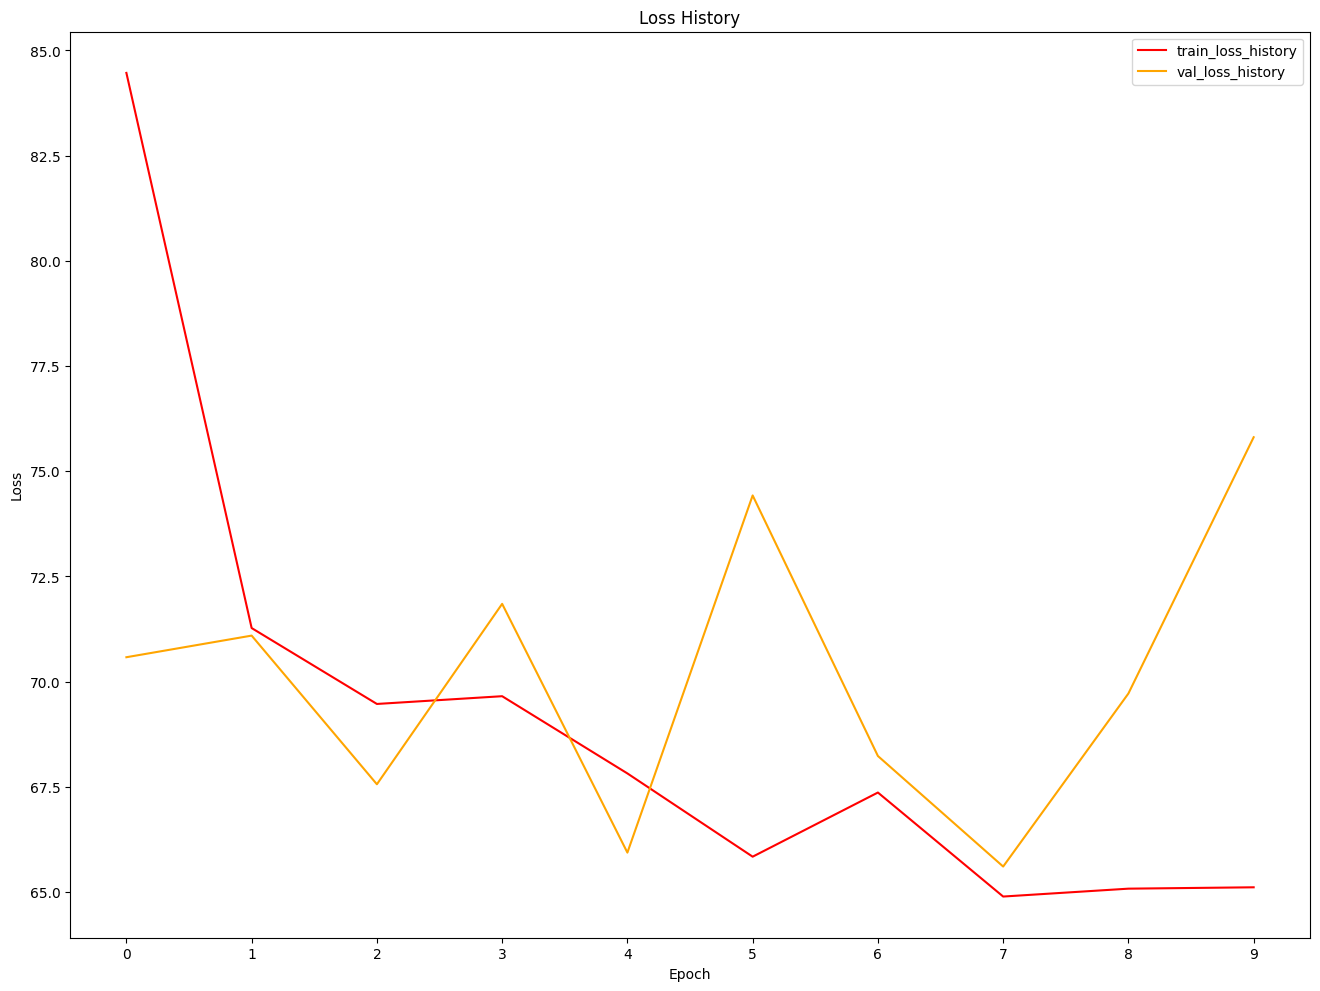

****************************************************************************************************
Final Avg Test Loss: 70.52634319154878
****************************************************************************************************

****************************************************************************************************
Sample Music ID 316 -
  Predicted Arousal for some time interval during chorus: [0.6288219598407572, 0.6550779393523127, 0.6273491940512523, 0.6122367030689286, 0.6095654278779726, 0.6210417585263985, 0.6187069178527754, 0.6121978745954293, 0.6120752147988879, 0.6022371705697243, 0.6129719571639546, 0.6130801094138869, 0.6120640610271889, 0.6121603790563717, 0.6186977122160298, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.6327104120402022, 0.63271041204020

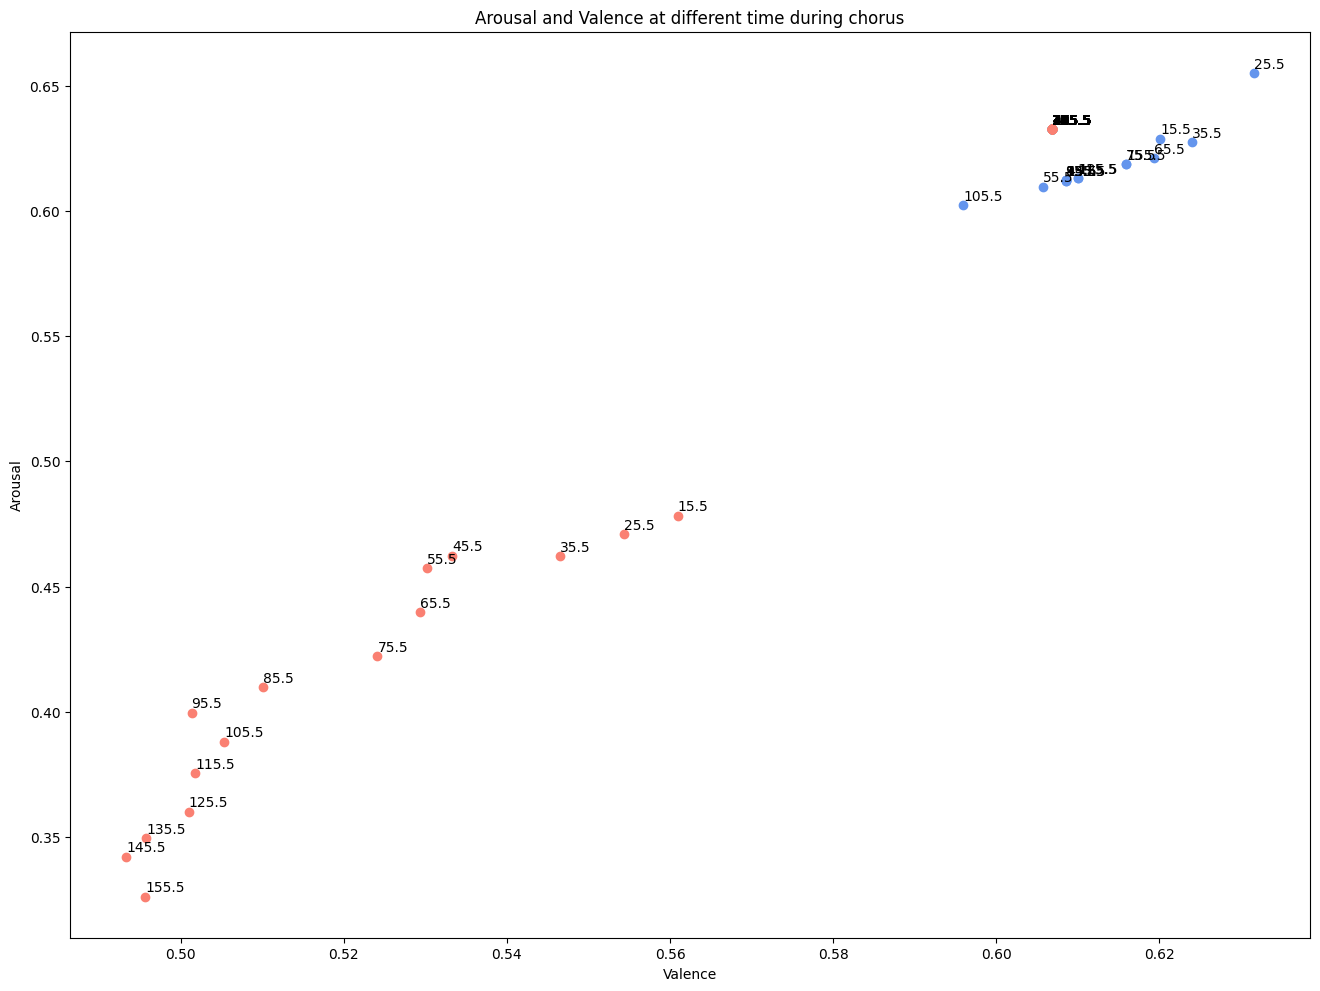

In [15]:
# define input data file
data_filename = f'/content/drive/MyDrive/Colab Notebooks/music_emotion_prediction_project/raw_dataset/dynamic_features.csv'
# define target label file
label_filename = f'/content/drive/MyDrive/Colab Notebooks/music_emotion_prediction_project/raw_dataset/dynamic_annotations.csv'
# define file for storing best model's state
best_model_filename = '/content/drive/MyDrive/Colab Notebooks/music_emotion_prediction_project/music_model.pt'
# define which model is used to be trained and there are two choices of model - BiLSTM or TransformerEncoder
model_to_train = 'TransformerEncoder'

# preprocess raw dataset (i.e., input data and target label)
input_dim, target_dim, data, label_d, label_begin, data_mean, data_var, label_mean, label_var = data_preprocessing(data_filename, label_filename)
# split preprocessed dataset into train, val, and test sets; and get a sample music index (from test set) for future comparison demonstration
train_data_X, train_d_Y, val_data_X, val_d_Y, test_data_X, test_d_Y, train_ids, val_ids, test_ids, sample_music, sample_music_idx = data_split(data, label_d)
# start training and validating model, and get the best model settings
best_model_name, best_model, best_config, best_loss, stats, loss_function, bidirectional = run(model_to_train, train_data_X, train_d_Y, val_data_X, val_d_Y, label_begin, data_mean, data_var, label_mean, label_var, device, best_model_filename)

# define file for storing loss plot
plot_filename = f'/content/drive/MyDrive/Colab Notebooks/music_emotion_prediction_project/plots/{best_model_name}.png'
# define file for storing sample music predictions plot
sample_music_filename = f'/content/drive/MyDrive/Colab Notebooks/music_emotion_prediction_project/plots/music_idx_{sample_music}_predictions.png'
# plot average training and validation loss 
plot_loss(stats, best_config, plot_filename)
# get final average test loss; and plot the emotion feature preditions of the chosen sample music
final_avg_test_loss = test_and_predict(best_model, best_model_filename, test_data_X, test_d_Y, label_begin, bidirectional, data_mean, data_var, label_mean, label_var, device, loss_function, test_ids, sample_music_idx, sample_music_filename)